inspiration: https://github.com/planetsig/ufo-reports  
dataset: https://www.kaggle.com/NUFORC/ufo-sightings


**Python was used for preliminary analysis, final visualizations were made using Tableau.**  
Presentation summarizing the visualizations: [Google Slides](https://docs.google.com/presentation/d/1JQ5GFWrafuAV3NTZVZhkr8ydXfZ6TlJ6O2hmbk2QF9w/edit?usp=sharing)

***
***

In [1]:
#uninstall geopy

In [2]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from scipy import stats
from scipy.stats import ttest_1samp, t, sem, norm

import warnings
warnings.filterwarnings('ignore')

***

In [3]:
path='/Users/manuelabueno/Documents/GitHub/UFOProject/scrubbed.csv'
df=pd.read_csv(path)

In [4]:
df

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
...,...,...,...,...,...,...,...,...,...,...,...
80327,9/9/2013 21:15,nashville,tn,us,light,600,10 minutes,Round from the distance/slowly changing colors...,9/30/2013,36.1658,-86.784444
80328,9/9/2013 22:00,boise,id,us,circle,1200,20 minutes,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,9/30/2013,43.6136,-116.202500
80329,9/9/2013 22:00,napa,ca,us,other,1200,hour,Napa UFO&#44,9/30/2013,38.2972,-122.284444
80330,9/9/2013 22:20,vienna,va,us,circle,5,5 seconds,Saw a five gold lit cicular craft moving fastl...,9/30/2013,38.9011,-77.265556


In [5]:
df.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')

In [6]:
df.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude               float64
dtype: object

***

**Problem:**

- Can we predict the `shape` of an UFO given on the `location`?
- Can we predict the `duration` of the appearance depending on the `date/time` ?

***
***

## 1. Cleaning 

**Datetime**  

In [7]:
# Check for null values
df['datetime'].isnull().sum()

0

In [8]:
# Split 'datetime' into a new dataframe
new = df['datetime'].str.split(" ", n = 1, expand = True) 
  
# Make separate 'date' and 'time' columns from new dataframe 
df["date"]= new[0] 
df["time"]= new[1] 
  
# Drop old 'datetime' column
df.drop(columns =["datetime"], inplace = True) 

In [9]:
# Create a column with only the year
df['year'] = df['date'].str[-4:]
df['year'] = df['year'].astype(int)
df['year'].unique()

array([1949, 1955, 1956, 1960, 1961, 1965, 1966, 1968, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1982, 1984, 1985,
       1986, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 1987, 1950, 1952, 1954, 1957, 1959,
       1967, 1969, 1981, 1983, 1936, 1943, 1953, 1962, 1964, 1958, 1963,
       1947, 2014, 1906, 1951, 1910, 1944, 1948, 1945, 1946, 1925, 1931,
       1933, 1916, 1920, 1930, 1939, 1941, 1942, 1937, 1929, 1934])

In [10]:
# Create a column with only the month
df['month'] = df['date'].str[:2]
df['month'] = df['month'].str.strip('/')
df['month'] = df['month'].astype(int)
df['month'].nunique()

12

In [11]:
# Clean 'date'
df['date'] = pd.to_datetime(df.date, format='%m/%d/%Y')

In [12]:
# Create a column with the day of the week for each sighting,
#   with Monday=0, Sunday=6
df['weekday'] = df['date'].dt.weekday
df['weekday'].nunique()

7

In [13]:
# Clean 'time'
#df['time'] = pd.to_timedelta(df.time + ':00')
df['time'] = df['time'].str.replace(':', '')
df['time'] = df['time'].astype(int)
df['time']

0        2030
1        2100
2        1700
3        2100
4        2000
         ... 
80327    2115
80328    2200
80329    2200
80330    2220
80331    2300
Name: time, Length: 80332, dtype: int64

In [14]:
# Check changes
df.columns

Index(['city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude ', 'date', 'time', 'year', 'month', 'weekday'],
      dtype='object')

In [15]:
df.dtypes

city                            object
state                           object
country                         object
shape                           object
duration (seconds)              object
duration (hours/min)            object
comments                        object
date posted                     object
latitude                        object
longitude                      float64
date                    datetime64[ns]
time                             int64
year                             int64
month                            int64
weekday                          int64
dtype: object

***

**Date Posted**

In [16]:
df.rename(columns={'date posted':'date_posted'}, inplace=True)

In [17]:
# Change the dtype to datetime
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%m/%d/%Y')
df['date_posted']

0       2004-04-27
1       2005-12-16
2       2008-01-21
3       2004-01-17
4       2004-01-22
           ...    
80327   2013-09-30
80328   2013-09-30
80329   2013-09-30
80330   2013-09-30
80331   2013-09-30
Name: date_posted, Length: 80332, dtype: datetime64[ns]

***

**Shape**

In [18]:
# Check for null values
df['shape'].isnull().sum()

1932

In [19]:
# Check the shapes
df['shape'].unique()

array(['cylinder', 'light', 'circle', 'sphere', 'disk', 'fireball',
       'unknown', 'oval', 'other', 'cigar', 'rectangle', 'chevron',
       'triangle', 'formation', nan, 'delta', 'changing', 'egg',
       'diamond', 'flash', 'teardrop', 'cone', 'cross', 'pyramid',
       'round', 'crescent', 'flare', 'hexagon', 'dome', 'changed'],
      dtype=object)

In [20]:
# Classify these shapes to reduce number of unique values:
circular = ['cylinder', 'circle', 'sphere', 'disk', 'oval', 'egg', 'round', 'dome', 'cigar', 'teardrop']
triangular = ['triangle', 'cone', 'pyramid', 'delta', 'crescent'] 
quadrilateral = ['rectangle', 'diamond']
hexagonal = ['hexagon', 'chevron']
complicated = ['cross', 'formation', 'changing', 'changed', 'other']
bright = ['light', 'fireball', 'flash', 'flare']
unspecified = ['unknown']

df['shape'] = np.where(df['shape'].isin(circular), 'circular', df['shape'])
df['shape'] = np.where(df['shape'].isin(triangular), 'triangular', df['shape'])
df['shape'] = np.where(df['shape'].isin(quadrilateral), 'quadrilateral', df['shape'])
df['shape'] = np.where(df['shape'].isin(hexagonal), 'hexagonal', df['shape'])
df['shape'] = np.where(df['shape'].isin(complicated), 'complicated', df['shape'])
df['shape'] = np.where(df['shape'].isin(bright), 'bright', df['shape'])
df['shape'] = np.where(df['shape'].isin(unspecified), 'unspecified', df['shape'])
df['shape'].fillna('unspecified', inplace=True)

In [21]:
 df['shape'].value_counts(normalize=True)

circular         0.333528
bright           0.300030
complicated      0.128243
triangular       0.101964
unspecified      0.093562
quadrilateral    0.030810
hexagonal        0.011863
Name: shape, dtype: float64

In [22]:
# Encode the unique values
#df['shape'] = df['shape'].astype('category')
#df['shape'] = df['shape'].cat.codes
#df['shape'].value_counts()

In [23]:
#bright         =  0
#circular       =  1
#complicated    =  2
#hexagonal      =  3
#quadrilateral  =  4
#triangular     =  5
#unspecified    =  6

***

**Duration in Seconds**

In [24]:
df.rename(columns={'duration (seconds)':'duration_seconds'}, inplace=True)

In [25]:
# Change dtype
df['duration_seconds'] = pd.to_numeric(df['duration_seconds'], errors='coerce')

In [26]:
# Check for null values
df[df['duration_seconds'].isnull()]

,city,state,country,shape,duration_seconds,duration (hours/min),comments,date_posted,latitude,longitude,date,time,year,month,weekday
27822,bouse,az,us,unspecified,NaN,each a few seconds,Driving through Plomosa Pass towards Bouse Loo...,2000-02-16,33.9325000,-114.005000,2000-02-02,1933,2000,2,2
35692,santa cruz,ca,us,unspecified,NaN,eight seconds,2 red lights moving together and apart with a ...,2005-04-16,36.9741667,-122.029722,2005-04-10,2252,2005,4,6
58591,ibague (colombia),NaN,NaN,circular,NaN,1/2 segundo,Viajaba a 27.000 pies en un avion comercial ve...,2006-10-30,4.440663,-75.244141,2006-07-21,1300,2006,7,4


In [27]:
# Since we can see the duration under (hours/min), we can update the 3 null values manually
df.at[27822, 'duration_seconds'] = 2.0
df.at[35692, 'duration_seconds'] = 8.0
df.at[58591, 'duration_seconds'] = 2.0

In [28]:
df['duration_seconds'].isnull().sum()

0

In [29]:
# What is the distirbution of durations we have
df['duration_seconds'].describe().round()

count       80332.0
mean         9017.0
std        620217.0
min             0.0
25%            30.0
50%           180.0
75%           600.0
max      97836000.0
Name: duration_seconds, dtype: float64

In [30]:
# We clearly have some outliers: 75% of the sightings last around 600 seconds (10 min) 
#  (which is still questionable but acceptable if we consider people tend to exagerate)
#  BUT our longest sighting apparently lasted 31 years... 
df.sort_values(by=['duration_seconds']).tail(4)

,city,state,country,shape,duration_seconds,duration (hours/min),comments,date_posted,latitude,longitude,date,time,year,month,weekday
64390,finley,wa,us,bright,52623200.0,2 months,There have been several flying objects in a pe...,2012-08-19,46.1541667,-119.032778,2012-08-10,2100,2012,8,4
74660,greenbrier,ar,us,bright,66276000.0,21 years,Orange or amber balls or orbs of light multipl...,2008-03-31,35.2339,-92.387500,1991-09-15,1800,1991,9,6
53384,ottawa (canada),on,ca,complicated,82800000.0,23000hrs,((HOAX??)) I was out in a field near mil&#44 ...,2010-07-06,45.416667,-75.700000,2010-06-03,2330,2010,6,3
559,birmingham (uk/england),NaN,gb,circular,97836000.0,31 years,Firstly&#44 I was stunned and stared at the ob...,2013-04-12,52.466667,-1.916667,1983-10-01,1700,1983,10,5


In [31]:
# There's a big chance these reports are incorrectly filed, or maybe they're refering to abductions!
# ...anyway the comments don't give any useful information or simply don't add up.
df['comments'].iloc[559]

'Firstly&#44 I was stunned and stared at the object for what seemed minutes&#44 but probably was only seconds. My first inclination was to bec'

In [32]:
# In some cases we clearly see the duration is actually the period of time these individuals saw the ufo's
# and not the duration of the sighting itself
df['comments'].iloc[64390]

'There have been several flying objects in a period of about two months that look like an orb of white light (resembling a star). They m'

In [33]:
df.shape

(80332, 15)

In [34]:
# Try to find outliers... 
#  If we look at all sightings over 1 hour (3600 seconds) we have 3201 rows, almost 4% of our entries,  
#    and some comments do say the appereance lasted around an hour... so maybe these are the long cases. 
#df[df['duration_seconds'] >= 3201]

#  Let's reduce our filter to sightings lasting more than 1 week (604800 seconds), we have 69 rows, pretty low,
#    we could drop but I'm convinced most of the entries with really long durations are filing errors.  
#df[df['duration_seconds'] >= 604800]

#  So let's increase our filter to sightings lasting more than 3 hours (10800 seconds),  #[1 day (86400 seconds)] 
#    we have 1450 rows, around 2%, dropable.
df[df['duration_seconds'] >= 10800]

,city,state,country,shape,duration_seconds,duration (hours/min),comments,date_posted,latitude,longitude,date,time,year,month,weekday
68,connersville,in,us,triangular,14400.0,4 hours,3 differants types &#44 cluster &#44delta &#44...,1999-01-28,39.6411111,-85.141111,1997-10-10,1600,1997,10,4
88,rachel,nv,us,bright,10800.0,3 hours,Bright lights with incredible agility seen fro...,2005-05-24,37.6447222,-115.742778,1999-10-10,2100,1999,10,6
122,temperance,mi,us,circular,18000.0,over 5 hours,pulsating green white and red object in the no...,2003-10-31,41.7791667,-83.568889,2003-10-10,2025,2003,10,4
123,crescent beach,sc,us,complicated,37800.0,1 1/2 hr.,For two consecutive nights&#44 we watched a pa...,2004-01-17,33.8075000,-78.701111,2003-10-10,2110,2003,10,4
165,lebanon,or,us,bright,14400.0,4 hours,Small Orange-White &quot;star&quot; that moves...,2007-11-28,44.5366667,-122.905833,2007-10-10,100,2007,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80031,niagara falls (canada),on,ca,bright,10800.0,3 hours,For about the past year I have seen 3 slightly...,2010-11-21,43.1,-79.050000,2010-09-08,2200,2010,9,2
80052,stroudsburg,pa,us,circular,14400.0,4 hours,Fourth sighting of UFOs in the week at the sam...,2012-09-24,40.9867,-75.195000,2012-09-08,200,2012,9,5
80057,rocky boy,mt,us,quadrilateral,10800.0,2-3 hours,Me &amp; a couple of friends went outside to s...,2012-09-24,48.2561,-109.787500,2012-09-08,1630,2012,9,5
80128,mount shasta,ca,us,unspecified,18000.0,5 hours,multiple anomalious lights&#44white flashes&#4...,1999-10-02,41.31,-122.309444,1999-09-09,2200,1999,9,3


In [35]:
# Drop rows where sighting reportedly lasted more than 1 day
df.drop(df[df['duration_seconds'] >= 10800].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(78882, 15)

In [36]:
# Change dtype from float to integer 
df['duration_seconds'] = df['duration_seconds'].astype(int)

In [37]:
df['duration_seconds'].describe().round()

count    78882.0
mean       617.0
std       1211.0
min          0.0
25%         30.0
50%        180.0
75%        600.0
max      10620.0
Name: duration_seconds, dtype: float64

In [38]:
# Now, given that 50% of sightings last around 3 minutes (180 seconds)
#  let's try to bin the column into 3 categories
df['duration'] = df['duration_seconds']

#0 to 120 sec = brief
#120 sec to 5 min = short
#5 min to min = medium
#1 hour and over = long
bins = [0, 120, 420, 3600]
names = ['brief', 'short', 'medium', 'long']

d = dict(enumerate(names, 1))

df['duration'] = np.vectorize(d.get)(np.digitize(df['duration'], bins))

In [39]:
df['duration'].value_counts(normalize=True)

brief     0.384967
short     0.300956
medium    0.263913
long      0.050164
Name: duration, dtype: float64

In [40]:
df['duration'].value_counts()

brief     30367
short     23740
medium    20818
long       3957
Name: duration, dtype: int64

In [41]:
# Encode
#df['duration'] = df['duration'].astype('category')
#df['duration'] = df['duration'].cat.codes
#df['duration'].value_counts()

In [42]:
#brief     =   0
#long      =   1
#momentary =   2
#short     =   3

***

[drop] **Duration in hours/min**

In [43]:
df.drop(['duration (hours/min)'], axis=1, inplace=True)

***

**City**

In [44]:
# Check for missing values
df.city.isnull().sum()

0

In [45]:
# No null values, but probably too many unique values
df.city.nunique()

19601

**State**

In [46]:
# Since this is a column for American states, the null values correspond to other countries
df.state.isnull().sum()

5677

In [47]:
df.state.nunique()

67

**Country**

In [48]:
# Check for missing values
df.country.isnull().sum()

9444

In [49]:
# Check the unique values
df.country.nunique()

5

In [50]:
# Not only is there a lot of missing values, some are also really sketchy or probably uncorrectly filed.
#  I tried to clean the columns (extra lines of code below) but I decided to try another method...

In [51]:
#  So let's drop these columns.
df.drop(['city','state','country'], axis=1, inplace=True)

In [52]:
# Merge state and country
#df['location'] = df.state.fillna(' ') + "/" + df.country.fillna(' ')
##df['location'] = df[['country', 'state']].apply(lambda x: '/'.join(x), axis = 1)

In [53]:
#df.location.isnull().sum()

In [54]:
# Clean the new columns
#?df['location'] = df['location'].str.strip()
#?df[df.location.apply(lambda x: len(x) <= 4)]
#?df[df.location == '/']

In [55]:
#df.location.value_counts()

***

**Latitude**

In [56]:
# Change the dtype to float
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

In [57]:
# Check for null values
df[df.latitude.isnull()]

,shape,duration_seconds,comments,date_posted,latitude,longitude,date,time,year,month,weekday,duration
42995,quadrilateral,180,Huge rectangular object emmitting intense whit...,2012-04-18,NaN,-105.624152,1974-05-22,530,1974,5,2,short


In [58]:
# Research and replace the null value
df['latitude'].iloc[42995] = 33.1911495

In [59]:
# Check again 
df.latitude.isnull().sum()

0

***

**Longitude**

In [60]:
# Change name
df.rename(columns={'longitude ':'longitude'}, inplace=True)

In [61]:
df['longitude'].isnull().sum()

0

***

[new] **Location**

In [62]:
df.columns

Index(['shape', 'duration_seconds', 'comments', 'date_posted', 'latitude',
       'longitude', 'date', 'time', 'year', 'month', 'weekday', 'duration'],
      dtype='object')

In [63]:
# Let's try to use the Latitude and Longitude to get clean information about the countires 
#  using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude,df.latitude))
df2 = gpd.sjoin(gdf, world, how='left', op='within')
df2

,shape,duration_seconds,comments,date_posted,latitude,longitude,date,time,year,month,weekday,duration,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
0,circular,2700,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,1949-10-10,2030,1949,10,0,medium,POINT (-97.94111 29.88306),4.0,326625791.0,North America,United States of America,USA,18560000.0
1,bright,7200,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,1949-10-10,2100,1949,10,0,long,POINT (-98.58108 29.38421),4.0,326625791.0,North America,United States of America,USA,18560000.0
2,circular,20,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,1955-10-10,1700,1955,10,0,brief,POINT (-2.91667 53.20000),143.0,64769452.0,Europe,United Kingdom,GBR,2788000.0
3,circular,20,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,1956-10-10,2100,1956,10,2,brief,POINT (-96.64583 28.97833),4.0,326625791.0,North America,United States of America,USA,18560000.0
4,bright,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611,1960-10-10,2000,1960,10,0,medium,POINT (-157.80361 21.41806),4.0,326625791.0,North America,United States of America,USA,18560000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78877,bright,600,Round from the distance/slowly changing colors...,2013-09-30,36.165833,-86.784444,2013-09-09,2115,2013,9,0,medium,POINT (-86.78444 36.16583),4.0,326625791.0,North America,United States of America,USA,18560000.0
78878,circular,1200,Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...,2013-09-30,43.613611,-116.202500,2013-09-09,2200,2013,9,0,medium,POINT (-116.20250 43.61361),4.0,326625791.0,North America,United States of America,USA,18560000.0
78879,complicated,1200,Napa UFO&#44,2013-09-30,38.297222,-122.284444,2013-09-09,2200,2013,9,0,medium,POINT (-122.28444 38.29722),4.0,326625791.0,North America,United States of America,USA,18560000.0
78880,circular,5,Saw a five gold lit cicular craft moving fastl...,2013-09-30,38.901111,-77.265556,2013-09-09,2220,2013,9,0,brief,POINT (-77.26556 38.90111),4.0,326625791.0,North America,United States of America,USA,18560000.0


In [64]:
# Unfortunatly, for some reason, we have some new missing values, 
#  but A LOT LESS than df origianlly had in country (9630)
df2.isnull().sum()

shape                  0
duration_seconds       0
comments              15
date_posted            0
latitude               0
longitude              0
date                   0
time                   0
year                   0
month                  0
weekday                0
duration               0
geometry               0
index_right         2254
pop_est             2254
continent           2254
name                2254
iso_a3              2254
gdp_md_est          2254
dtype: int64

In [65]:
# Drop the rows with missing values
df2.dropna(subset=['index_right'], inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.shape

(76628, 19)

In [66]:
# Check again
df2.isnull().sum()

shape                0
duration_seconds     0
comments            14
date_posted          0
latitude             0
longitude            0
date                 0
time                 0
year                 0
month                0
weekday              0
duration             0
geometry             0
index_right          0
pop_est              0
continent            0
name                 0
iso_a3               0
gdp_md_est           0
dtype: int64

In [67]:
# Check the unique values
df2.iso_a3.unique()

array(['USA', 'GBR', 'CAN', 'NZL', 'RUS', 'AUS', 'LTU', '-99', 'ISL',
       'PRI', 'MEX', 'AUT', 'JPN', 'VNM', 'TUR', 'CHN', 'GRC', 'IRQ',
       'MYS', 'ARM', 'CHL', 'IDN', 'IND', 'HUN', 'DEU', 'PHL', 'VEN',
       'PAK', 'IRN', 'AFG', 'MAR', 'TWN', 'SAU', 'SWZ', 'HRV', 'COL',
       'PSE', 'EGY', 'POL', 'SRB', 'ZAF', 'PAN', 'BEL', 'KOR', 'HND',
       'SWE', 'ITA', 'NLD', 'IRL', 'DOM', 'MKD', 'ARG', 'NAM', 'BGD',
       'JAM', 'SYR', 'ARE', 'THA', 'GRL', 'KWT', 'ROU', 'ESP', 'UKR',
       'BGR', 'SVK', 'TUN', 'DZA', 'TTO', 'FIN', 'LBN', 'LBY', 'LKA',
       'ISR', 'CRI', 'BIH', 'LVA', 'SUR', 'UZB', 'GHA', 'BRA', 'NPL',
       'BOL', 'PRT', 'CYP', 'JOR', 'MMR', 'SVN', 'DNK', 'LUX', 'BRN',
       'CUB', 'ZWE', 'AZE', 'FJI', 'PRY', 'EST', 'OMN', 'LSO', 'NGA',
       'CHE', 'GUY', 'PER', 'BLR', 'GTM', 'CZE', 'KGZ', 'BLZ', 'ECU',
       'KEN', 'SLV', 'TZA', 'ZMB', 'KHM', 'ETH', 'CMR', 'TLS', 'ALB',
       'SEN', 'BWA', 'URY', 'ATA', 'GEO', 'UGA', 'QAT', 'BHS', 'KAZ',
       'COD', 'MNG',

In [68]:
# Fix '-99'
df2[df2.iso_a3 == '-99']

,shape,duration_seconds,comments,date_posted,latitude,longitude,date,time,year,month,weekday,duration,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
173,bright,600,Thise could be an ETV case&#44 but it could al...,2008-01-21,59.900209,5.282347,2007-10-10,2320,2007,10,2,medium,POINT (5.28235 59.90021),21.0,5320045.0,Europe,Norway,-99,364700.0
887,circular,180,Huge grey cylinder rotating going down to my h...,2011-12-12,48.945484,2.037356,2011-10-01,1700,2011,10,5,short,POINT (2.03736 48.94548),43.0,67106161.0,Europe,France,-99,2699000.0
994,complicated,2,The craft was too dark&#44 but behind i have s...,2001-10-12,48.097456,-0.349277,2001-10-12,1940,2001,10,4,brief,POINT (-0.34928 48.09746),43.0,67106161.0,Europe,France,-99,2699000.0
1026,circular,2700,Round sphere off the coast of southern France.,2013-05-15,43.580418,7.125102,2004-10-12,1500,2004,10,1,medium,POINT (7.12510 43.58042),43.0,67106161.0,Europe,France,-99,2699000.0
1811,unspecified,120,Two red lights in the sky,2002-10-28,48.834913,2.523649,1994-10-15,2200,1994,10,5,short,POINT (2.52365 48.83491),43.0,67106161.0,Europe,France,-99,2699000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74014,quadrilateral,1320,Black little square floating in the sky&#44 No...,2006-05-15,50.665802,3.210788,2005-09-25,1941,2005,9,6,medium,POINT (3.21079 50.66580),43.0,67106161.0,Europe,France,-99,2699000.0
74057,complicated,10,the looking like afterburning lights moved ste...,2008-10-31,44.758106,4.598572,2008-09-25,2315,2008,9,3,brief,POINT (4.59857 44.75811),43.0,67106161.0,Europe,France,-99,2699000.0
75234,quadrilateral,2,Threre was a C30 military transport fly at 200...,2002-09-13,48.117266,-1.677793,2002-09-03,1200,2002,9,1,brief,POINT (-1.67779 48.11727),43.0,67106161.0,Europe,France,-99,2699000.0
75765,circular,1800,bright white light movement,2011-10-10,48.253243,-3.825407,2011-09-05,10,2011,9,0,medium,POINT (-3.82541 48.25324),43.0,67106161.0,Europe,France,-99,2699000.0


In [69]:
# France and Norway have '-99' as their code, change to FRA and NOR
df2.loc[df2.name == 'France', 'iso_a3'] = 'FRA'
df2.loc[df2.name == 'Norway', 'iso_a3'] = 'NOR'

In [70]:
# N. Cyprus and Kosovo also have '-99' as their code, change to CYP and RKS
df2.loc[df2.name == 'N. Cyprus', 'iso_a3'] = 'CYP'
df2.loc[df2.name == 'Kosovo', 'iso_a3'] = 'RKS'

In [71]:
df2.iso_a3.isnull().sum()

0

In [72]:
df2.continent.unique()

array(['North America', 'Europe', 'Oceania', 'Asia', 'South America',
       'Africa', 'Antarctica'], dtype=object)

In [73]:
df2.name.unique()

array(['United States of America', 'United Kingdom', 'Canada',
       'New Zealand', 'Russia', 'Australia', 'Lithuania', 'Norway',
       'Iceland', 'Puerto Rico', 'Mexico', 'Austria', 'Japan', 'Vietnam',
       'Turkey', 'China', 'Greece', 'Iraq', 'Malaysia', 'Armenia',
       'France', 'Chile', 'Indonesia', 'India', 'Hungary', 'Germany',
       'Philippines', 'Venezuela', 'Pakistan', 'Iran', 'Afghanistan',
       'Morocco', 'Taiwan', 'Saudi Arabia', 'eSwatini', 'Croatia',
       'Colombia', 'Palestine', 'Egypt', 'Poland', 'Serbia',
       'South Africa', 'Panama', 'Belgium', 'South Korea', 'Honduras',
       'Sweden', 'Italy', 'Netherlands', 'Ireland', 'Dominican Rep.',
       'Macedonia', 'Argentina', 'N. Cyprus', 'Namibia', 'Bangladesh',
       'Jamaica', 'Syria', 'United Arab Emirates', 'Thailand',
       'Greenland', 'Kuwait', 'Romania', 'Spain', 'Ukraine', 'Bulgaria',
       'Slovakia', 'Tunisia', 'Algeria', 'Trinidad and Tobago', 'Finland',
       'Kosovo', 'Lebanon', 'Libya', 

In [74]:
#geolocator = Nominatim(user_agent='manubueno96@hotmail.com')
#location = geolocator.reverse("52.509669, 13.376294")
#print(location.raw)

***

**Final Dataframe for Analysis**

In [75]:
finaltable = df2.copy()

In [76]:
finaltable.columns

Index(['shape', 'duration_seconds', 'comments', 'date_posted', 'latitude',
       'longitude', 'date', 'time', 'year', 'month', 'weekday', 'duration',
       'geometry', 'index_right', 'pop_est', 'continent', 'name', 'iso_a3',
       'gdp_md_est'],
      dtype='object')

In [77]:
# Drop unnecesary columns
finaltable.drop(['index_right', 'pop_est', 'gdp_md_est'], axis=1, inplace=True)

In [78]:
finaltable.columns

Index(['shape', 'duration_seconds', 'comments', 'date_posted', 'latitude',
       'longitude', 'date', 'time', 'year', 'month', 'weekday', 'duration',
       'geometry', 'continent', 'name', 'iso_a3'],
      dtype='object')

In [79]:
# Reorganise the columns 
finaltable = finaltable[['date', 'weekday', 'month', 'year', 'time', 
                         'name', 'iso_a3', 'continent', 
                         'latitude','longitude', 'geometry',
                         'shape', 'duration', 'duration_seconds', 'comments', 'date_posted']]

In [80]:
# Rename some of the columns
finaltable.rename(columns={'iso_a3':'country_code'}, inplace=True)

In [81]:
finaltable.to_csv('finaltable.csv')

In [82]:
# Check for missing values one last time
finaltable.isnull().sum()

date                 0
weekday              0
month                0
year                 0
time                 0
name                 0
country_code         0
continent            0
latitude             0
longitude            0
geometry             0
shape                0
duration             0
duration_seconds     0
comments            14
date_posted          0
dtype: int64

In [83]:
# Check the dtypes one last time
finaltable.dtypes

date                datetime64[ns]
weekday                      int64
month                        int64
year                         int64
time                         int64
name                        object
country_code                object
continent                   object
latitude                   float64
longitude                  float64
geometry                  geometry
shape                       object
duration                    object
duration_seconds             int64
comments                    object
date_posted         datetime64[ns]
dtype: object

In [84]:
# Make a copy of the finaltable to do some statistical analysis
adf = finaltable.copy()
adf.columns

Index(['date', 'weekday', 'month', 'year', 'time', 'name', 'country_code',
       'continent', 'latitude', 'longitude', 'geometry', 'shape', 'duration',
       'duration_seconds', 'comments', 'date_posted'],
      dtype='object')

In [85]:
# Drop unnecesary columns
adf.drop(['date', 'name', 'latitude', 'longitude', 'geometry', 'comments', 'date_posted'], axis=1, inplace=True)

In [86]:
adf.dtypes

weekday              int64
month                int64
year                 int64
time                 int64
country_code        object
continent           object
shape               object
duration            object
duration_seconds     int64
dtype: object

In [87]:
# Encode the unique values from shapes
adf['shape'] = adf['shape'].astype('category')
adf['shape'] = adf['shape'].cat.codes
adf['shape'].value_counts()

1    25583
0    22948
2     9777
5     7872
6     7117
4     2405
3      926
Name: shape, dtype: int64

In [88]:
#bright         =  0
#circular       =  1
#complicated    =  2
#hexagonal      =  3
#quadrilateral  =  4
#triangular     =  5
#unspecified    =  6

In [89]:
# Encode the unique values from duration
adf['duration'] = adf['duration'].astype('category')
adf['duration'] = adf['duration'].cat.codes
adf['duration'].value_counts()

0    29507
3    23073
2    20214
1     3834
Name: duration, dtype: int64

In [90]:
#brief  =   0
#long   =   1
#medium =   2
#short  =   3

In [91]:
# Encode country code and continent as well
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

adf['continent'] = le.fit_transform(adf['continent'])
adf['country_code'] = le.fit_transform(adf['country_code'])

In [92]:
list(le.classes_)

['AFG',
 'ALB',
 'ARE',
 'ARG',
 'ARM',
 'ATA',
 'AUS',
 'AUT',
 'AZE',
 'BEL',
 'BGD',
 'BGR',
 'BHS',
 'BIH',
 'BLR',
 'BLZ',
 'BOL',
 'BRA',
 'BRN',
 'BWA',
 'CAN',
 'CHE',
 'CHL',
 'CHN',
 'CMR',
 'COD',
 'COL',
 'CRI',
 'CUB',
 'CYP',
 'CZE',
 'DEU',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FJI',
 'FRA',
 'GBR',
 'GEO',
 'GHA',
 'GRC',
 'GRL',
 'GTM',
 'GUY',
 'HND',
 'HRV',
 'HUN',
 'IDN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KOR',
 'KWT',
 'LAO',
 'LBN',
 'LBY',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAR',
 'MEX',
 'MKD',
 'MMR',
 'MNG',
 'MYS',
 'NAM',
 'NGA',
 'NLD',
 'NOR',
 'NPL',
 'NZL',
 'OMN',
 'PAK',
 'PAN',
 'PER',
 'PHL',
 'POL',
 'PRI',
 'PRT',
 'PRY',
 'PSE',
 'QAT',
 'RKS',
 'ROU',
 'RUS',
 'SAU',
 'SEN',
 'SLV',
 'SRB',
 'SUR',
 'SVK',
 'SVN',
 'SWE',
 'SWZ',
 'SYR',
 'THA',
 'TLS',
 'TTO',
 'TUN',
 'TUR',
 'TWN',
 'TZA',
 'UGA',
 'UKR',
 'URY',
 'USA',


In [93]:
finaltable.head(5)

,date,weekday,month,year,time,name,country_code,continent,latitude,longitude,geometry,shape,duration,duration_seconds,comments,date_posted
0,1949-10-10,0,10,1949,2030,United States of America,USA,North America,29.883056,-97.941111,POINT (-97.94111 29.88306),circular,medium,2700,This event took place in early fall around 194...,2004-04-27
1,1949-10-10,0,10,1949,2100,United States of America,USA,North America,29.384210,-98.581082,POINT (-98.58108 29.38421),bright,long,7200,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16
2,1955-10-10,0,10,1955,1700,United Kingdom,GBR,Europe,53.200000,-2.916667,POINT (-2.91667 53.20000),circular,brief,20,Green/Orange circular disc over Chester&#44 En...,2008-01-21
3,1956-10-10,2,10,1956,2100,United States of America,USA,North America,28.978333,-96.645833,POINT (-96.64583 28.97833),circular,brief,20,My older brother and twin sister were leaving ...,2004-01-17
4,1960-10-10,0,10,1960,2000,United States of America,USA,North America,21.418056,-157.803611,POINT (-157.80361 21.41806),bright,medium,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22


In [94]:
adf.head(5)

,weekday,month,year,time,country_code,continent,shape,duration,duration_seconds
0,0,10,1949,2030,124,4,1,2,2700
1,0,10,1949,2100,124,4,0,1,7200
2,0,10,1955,1700,43,3,1,0,20
3,2,10,1956,2100,124,4,1,0,20
4,0,10,1960,2000,124,4,0,2,900


***
***

## 2. Analysis

- Countries with the most reported sightings 
    - In countries with the most reported sightings, regions with the most sightings

- Most seen shape

- Average duration of sightings

- Average time waited between sighting and report  

- Time of day these sightings occur the most
- Day of the week these sightings occur the most

In [95]:
finaltable.columns

Index(['date', 'weekday', 'month', 'year', 'time', 'name', 'country_code',
       'continent', 'latitude', 'longitude', 'geometry', 'shape', 'duration',
       'duration_seconds', 'comments', 'date_posted'],
      dtype='object')

In [96]:
adf.columns

Index(['weekday', 'month', 'year', 'time', 'country_code', 'continent',
       'shape', 'duration', 'duration_seconds'],
      dtype='object')

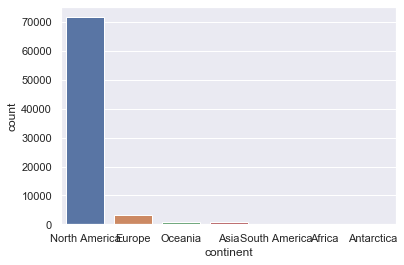

In [97]:
# Countries with the most reported sightings 
ax = sns.countplot(x="continent", data=finaltable)

In [98]:
north_america = finaltable[finaltable['continent'] == 'North America']
europe = finaltable[finaltable['continent'] == 'Europe']

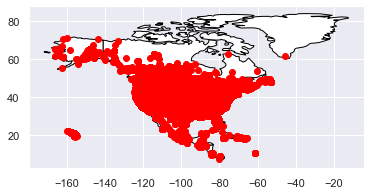

In [99]:
#Closer look to North America
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')

#To see what regions have the most sightings
north_america.plot(ax=ax, color='red')
plt.show()

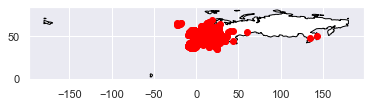

In [100]:
#Closer look to Europe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'Europe'].plot(color='white', edgecolor='black')

#To see what regions have the most sightings
europe.plot(ax=ax, color='red')
plt.show()

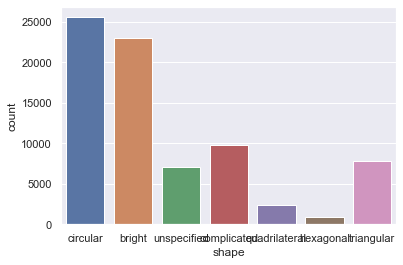

In [101]:
# Most seen shape
ax = sns.countplot(x="shape", data=finaltable)

In [102]:
# Most commun shape (1 = cirucular)
adf["shape"].mean()

1.8217492300464582

In [103]:
# Average shape per country
adf.groupby(by='country_code').mean().sort_values(by='shape')

,weekday,month,year,time,continent,shape,duration,duration_seconds
country_code,,,,,,,,
105,4.000000,6.500000,2002.500000,215.000000,0.0,0.000000,1.500000,180.0
34,2.000000,10.000000,2012.000000,500.000000,0.0,0.000000,0.000000,60.0
44,4.000000,5.000000,2009.000000,2110.000000,2.0,0.000000,0.000000,15.0
120,4.000000,1.000000,2009.000000,1940.000000,0.0,0.000000,0.000000,4.0
5,6.000000,5.000000,1994.000000,1300.000000,1.0,0.000000,0.000000,2.0
...,...,...,...,...,...,...,...,...
24,1.000000,4.000000,2006.000000,2313.000000,0.0,4.000000,2.000000,720.0
4,0.666667,6.333333,2010.666667,2146.333333,2.0,4.333333,1.333333,360.0
19,1.000000,6.000000,2008.000000,1830.000000,0.0,5.000000,2.000000,2250.0


In [104]:
list(le.classes_)[105]

'SEN'

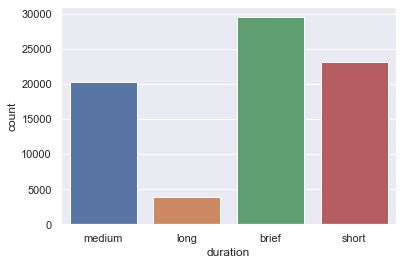

In [105]:
# Most commun range of duration
ax = sns.countplot(x="duration", data=finaltable)

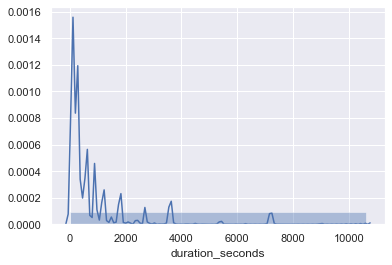

In [106]:
# Distribution of duration of sightings
ax = sns.distplot(adf["duration_seconds"], bins=1)

In [107]:
# Average duration of sighting in seconds (616s = 10min)
adf["duration_seconds"].mean()

616.346087592003

In [108]:
# Average duration in seconds per country
finaltable.groupby(by='country_code').mean().sort_values(by='duration_seconds')

,weekday,month,year,time,latitude,longitude,duration_seconds
country_code,,,,,,,
ATA,6.000000,5.000000,1994.000000,1300.0,-82.862752,-135.000000,2.000000
TZA,4.000000,1.000000,2009.000000,1940.0,-6.800000,39.283333,4.000000
GHA,3.000000,11.000000,2005.000000,1830.0,5.550000,-0.200000,5.000000
OMN,4.000000,1.000000,2014.000000,2115.0,23.610000,58.540000,15.000000
GEO,4.000000,5.000000,2009.000000,2110.0,41.716667,44.783333,15.000000
...,...,...,...,...,...,...,...
BLZ,1.500000,4.000000,2007.000000,1550.0,17.220633,-88.632297,2040.000000
IDN,3.800000,8.466667,2008.733333,1353.0,-3.223705,104.681860,2106.466667
BWA,1.000000,6.000000,2008.000000,1830.0,-24.658056,25.912222,2250.000000


In [109]:
# Average time waited between sighting and report  

In [110]:
# Time of day these sightings occur the most
# Day of the week these sightings occur the most

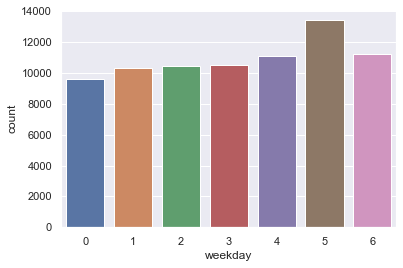

In [111]:
# Most commun day of the week these sightings occur on
ax = sns.countplot(x="weekday", data=finaltable)

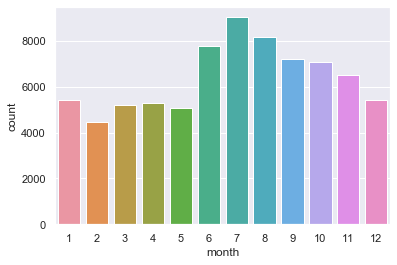

In [112]:
# Most commun month of the year these sightings occur on
ax = sns.countplot(x="month", data=finaltable)

In [113]:
adf['year'].describe()

count    76628.000000
mean      2003.900559
std         10.369360
min       1910.000000
25%       2001.000000
50%       2006.000000
75%       2011.000000
max       2014.000000
Name: year, dtype: float64

In [114]:
adf['year'].value_counts()

2012    7030
2013    6722
2011    4870
2008    4636
2009    4339
        ... 
1929       1
1930       1
1934       1
1941       1
1920       1
Name: year, Length: 86, dtype: int64

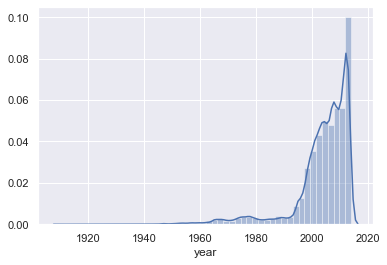

In [115]:
# Normally, the amount the sightings should be increasing since more and more poeple are reporting cases   
ax = sns.distplot(adf["year"])

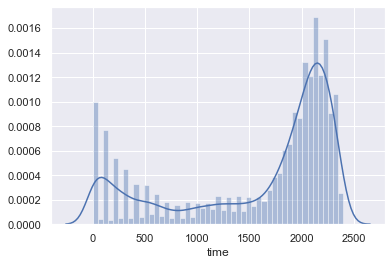

In [116]:
ax = sns.distplot(adf["time"])

In [117]:
# Check averag/longest time taken to report 

In [118]:
# Check average time taken to report for cases before 1990 

In [119]:
# Check average time taken to report for cases after 1990 

***

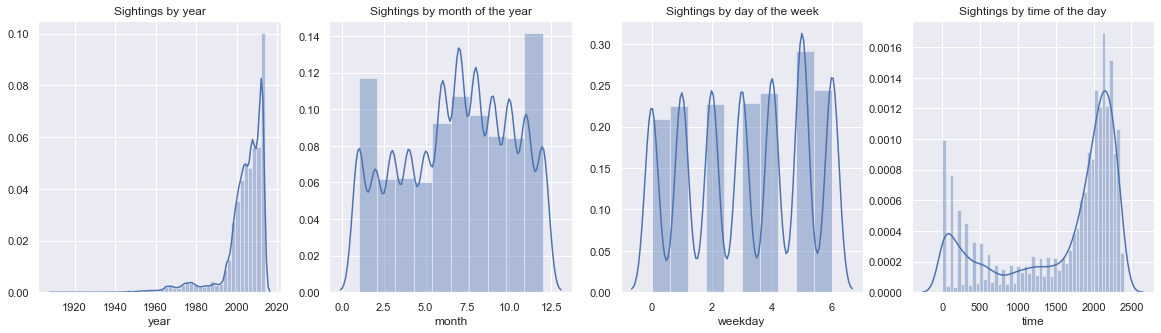

In [120]:
#Plot distributions for the main features
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(20, 5)
  

ax1.set_title('Sightings by year')
sns.distplot(adf.year, ax=ax1)

ax2.set_title('Sightings by month of the year')
sns.distplot(adf.month, ax=ax2, bins=10)

ax3.set_title('Sightings by day of the week')
sns.distplot(adf.weekday, ax=ax3,  bins=10)

ax4.set_title('Sightings by time of the day')
sns.distplot(adf.time, ax=ax4)



plt.show()

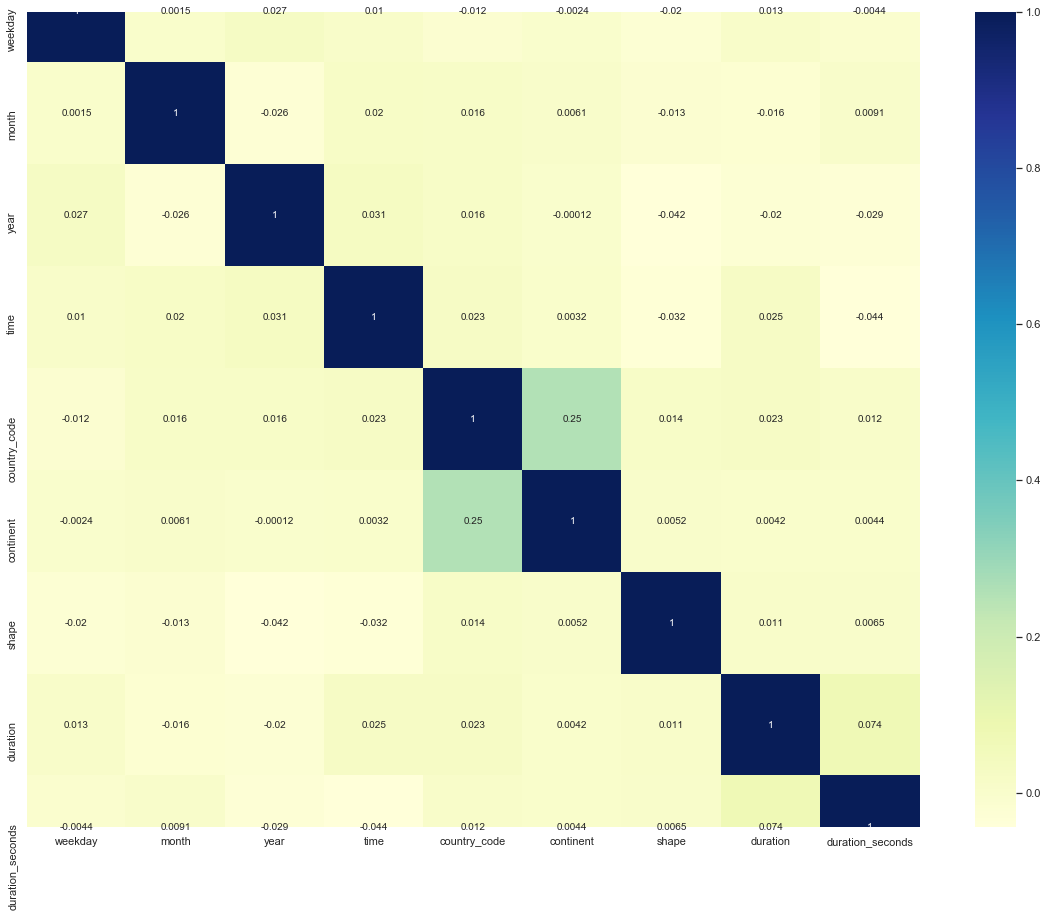

In [121]:
# Print Heatmap
corrMatrix=adf.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True)
plt.show()

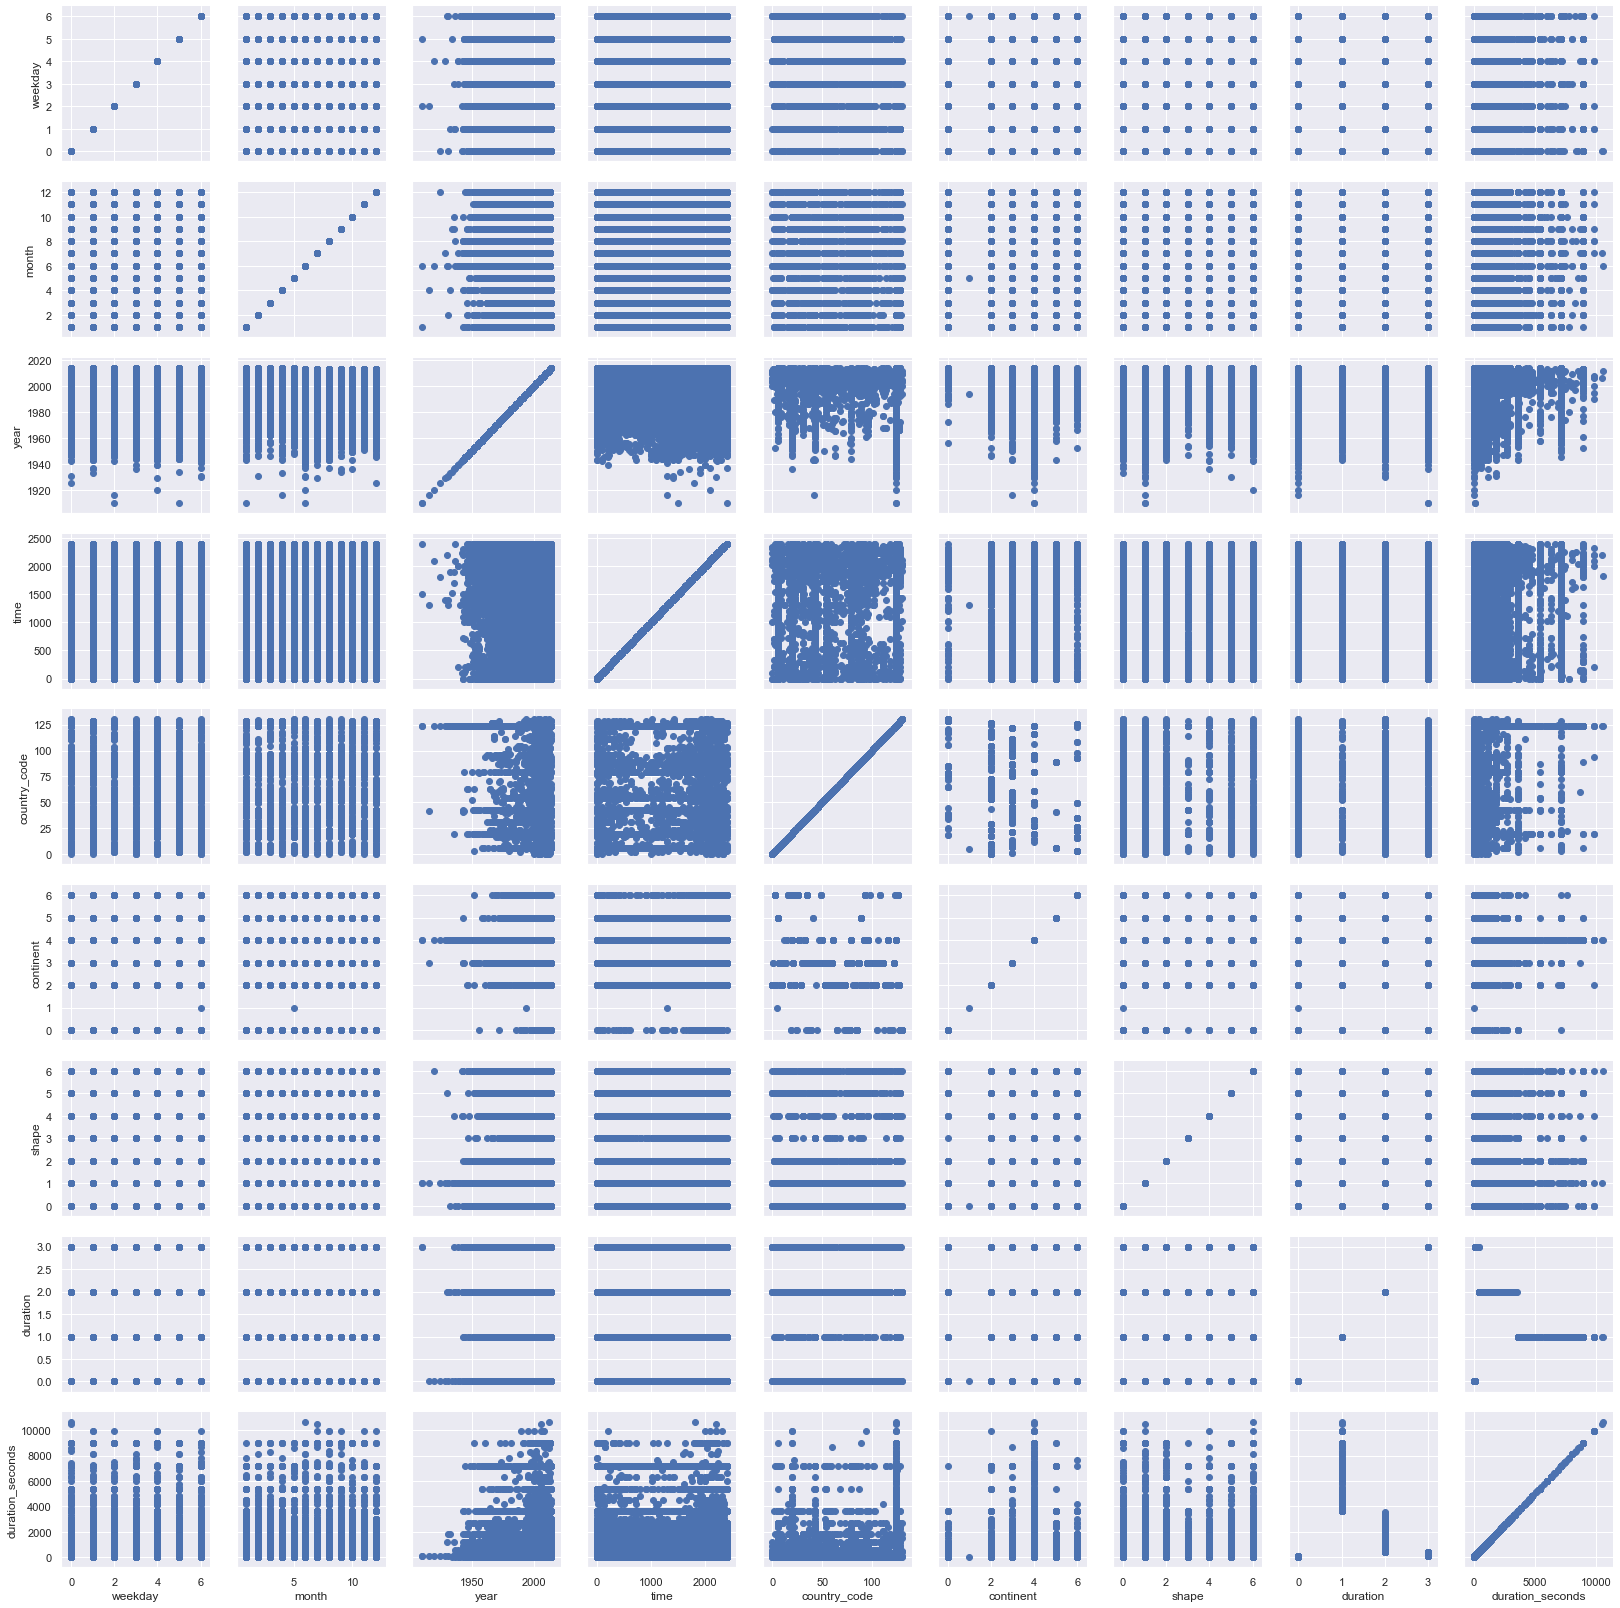

In [122]:
# Print Scatter Plot
g = sns.PairGrid(adf)
g = g.map(plt.scatter)

***
***

## 3. Modelling

**acc** = Accuracy   
`True Positive + True Negative`  
*= how many correct answers we get*  

**pr1** = Precision   
`True P / True P + False P`  
*= out of all positives, how many positives did we manage to predict*  

**rec1** = Recall   
`True P / True P + F N`   
*= out of all positives we predicted, how much are actually positive*  

**f11**  
`2 * (precision * recall) / (precision + recall)`   
*some sort of average between precision and recall*   

In [123]:
# importing necessary libraries 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve


#import joblib

### 3.1 Duration

- Can we predict the `duration` of the sighting ?

**Confidence Interval**

In [124]:
#Calculate variables:
 #sample = duration in seconds
ds = adf['duration_seconds']
 #average duration in seconds 
dsmean = ds.mean()
 #standard deviation of ds  
dsstd = ds.std()
 #standard error of ds
dssem = ds.sem()

#Compute confidence interval of the duration with confidence level of 95%
ci_ds = t.interval(0.95, df=ds.shape[0]-1, loc=dsmean, scale=dssem)
print("The average sighting in our sample lasts bewteen", round(ci_ds[0],2), 
      "and", round(ci_ds[1],2), "seconds.")

The average sighting in our sample lasts bewteen 607.78 and 624.92 seconds.


**Two-Tailed One-Sample T-Test**

In [125]:
#H0 (null hypothesis): most sightings last 616 seconds (around 10 minutes)
#H1 (alternative hypothesis): most sightings no dot last 616 seconds (around 10 minutes)

stat,pvalue = stats.ttest_1samp(ds,616) 

if pvalue < 0.05:
    print('stat =', stat, '/ pvalue =', pvalue,
          '\n\nSince pvalue is less than 0.05, we reject the null hypothesis in favor of the alternative.',
          '\n\nMost sightings do not last not 616 seconds.')
else:
    print('stat =', stat, '/ pvalue =', pvalue,
          '\n\nSince pvalue is greater than 0.05, we accept the null hypothesis.',
          '\n\nMost sightings last 616 seconds.')

stat = 0.0791554611085441 / pvalue = 0.936909176965081 

Since pvalue is greater than 0.05, we accept the null hypothesis. 

Most sightings last 616 seconds.


**One-Tailed One-Sample T-Test**

In [126]:
#H0 (null hypothesis) = most sightings are greater or equal to 616 seconds (around 10 minutes) 
#H1 (alternative hypothesis) = most sightings last less than 616 seconds (around 10 minutes)

stat,pvalue = stats.ttest_1samp(ds,616) 

if (pvalue / 2) < 0.05:
    print('stat =', stat, '/ pvalue =', pvalue,
          '\n\nSince pvalue divided by 2 is smaller than 0.05, we reject the null hypothesis in favor of the alternative.',
          '\n\nMost sightings last less than 616 seconds.')
else:
    print('stat =', stat, '/ pvalue =', pvalue,
          '\n\nSince pvalue divided by 2 is greater than 0.05, we accept the null hypothesis.',
          '\n\nMost sightings are greater or equal to 616 seconds.')

stat = 0.0791554611085441 / pvalue = 0.936909176965081 

Since pvalue divided by 2 is greater than 0.05, we accept the null hypothesis. 

Most sightings are greater or equal to 616 seconds.


**Modelling**

In [128]:
ufo.dtypes

weekday             int64
month               int64
year                int64
time                int64
country_code        int64
continent           int64
shape                int8
duration             int8
duration_seconds    int64
dtype: object

In [127]:
# loading the dataset 
ufo = adf.copy() 

In [129]:
# X -> features, y -> label 
X = ufo.drop('duration_seconds',axis=1) 
y = ufo['duration_seconds'] 
  
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

**Descision Tree Classifier**

In [130]:
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
y_pred1=dtree_model.predict(X_test)

# creating a confusion matrix 
conf1=confusion_matrix(y_test,y_pred1)
display(conf1)

acc1=accuracy_score(y_test,y_pred1)
rec1=recall_score(y_test,y_pred1, average='weighted')
pr1=precision_score(y_test,y_pred1, average='weighted')
f11=f1_score(y_test,y_pred1, average='weighted')

print(acc1,pr1,rec1,f11)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

0.2638200135720624 0.07582920112541724 0.2638200135720624 0.11638938316979264


In [131]:
confusion_matrix(y_train,dtree_model.predict(X_train))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**Logistic Regression**

In [132]:
# training a LogisticRegression
lregression_model=LogisticRegression().fit(X_train,y_train)
y_pred2=lregression_model.predict(X_test)

# creating a confusion matrix 
conf2=confusion_matrix(y_test,y_pred2)
display(conf2)

acc2=accuracy_score(y_test,y_pred2)
rec2=recall_score(y_test,y_pred2, average='weighted')
pr2=precision_score(y_test,y_pred2, average='weighted')
f12=f1_score(y_test,y_pred2, average='weighted')

print(acc2,pr2,rec2,f12)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

0.26366341285169914 0.10273375874899515 0.26366341285169914 0.11523337488517281


In [133]:
confusion_matrix(y_train,lregression_model.predict(X_train)) 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

***

### 3.2 Shape

- Can we predict the `shape` of an UFO ?

**Modelling**

In [134]:
# loading the dataset 
ufo = finaltable.copy() 
ufo.drop(['date', 'name', 'latitude', 'longitude', 'geometry', 'comments', 'date_posted', 'duration'], axis=1, inplace=True)

In [135]:
# Encode country code and continent as well
le = preprocessing.LabelEncoder()

ufo['continent'] = le.fit_transform(ufo['continent'])
ufo['country_code'] = le.fit_transform(ufo['country_code'])

In [136]:
ufo.dtypes

weekday              int64
month                int64
year                 int64
time                 int64
country_code         int64
continent            int64
shape               object
duration_seconds     int64
dtype: object

In [137]:
# X -> features, y -> label 
X = ufo.drop('shape',axis=1) 
y = ufo['shape'] 
  
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

**Decision Tree Classifier**

In [138]:
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier().fit(X_train,y_train)
y_pred1=dtree_model.predict(X_test)

# creating a confusion matrix 
conf1=confusion_matrix(y_test,y_pred1)
display(conf1)

acc1=accuracy_score(y_test,y_pred1)
rec1=recall_score(y_test,y_pred1, average='weighted')
pr1=precision_score(y_test,y_pred1, average='weighted')
f11=f1_score(y_test,y_pred1, average='weighted')

print(acc1,pr1,rec1,f11)

array([[2026, 1684,  676,   75,  154,  596,  556],
       [1695, 2292,  830,   71,  221,  616,  619],
       [ 656,  764,  384,   34,   78,  273,  235],
       [  62,   72,   29,    6,   13,   28,   16],
       [ 172,  206,   76,   15,   34,   72,   63],
       [ 561,  608,  236,   30,   69,  292,  185],
       [ 496,  532,  231,   21,   41,  175,  281]])

0.27744427624367074 0.28078210610613863 0.27744427624367074 0.27903882528539387


In [139]:
confusion_matrix(y_train,dtree_model.predict(X_train))

array([[17151,    21,     2,     1,     1,     1,     4],
       [  279, 18955,     3,     1,     0,     1,     0],
       [  129,    89,  7135,     0,     0,     0,     0],
       [   15,     6,     4,   675,     0,     0,     0],
       [   24,    23,     7,     2,  1710,     1,     0],
       [   91,    75,    31,     3,     3,  5688,     0],
       [   94,    47,    37,     1,     4,    19,  5138]])

**Logistic Regression**

In [140]:
# training a LogisticRegression
lregression_model=LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train,y_train)
y_pred2=lregression_model.predict(X_test)

# creating a confusion matrix 
conf2=confusion_matrix(y_test,y_pred2)
display(conf2)

acc2=accuracy_score(y_test,y_pred2)
rec2=recall_score(y_test,y_pred2, average='weighted')
pr2=precision_score(y_test,y_pred2, average='weighted')
f12=f1_score(y_test,y_pred2, average='weighted')

print(acc2,pr2,rec2,f12)

array([[1976, 3791,    0,    0,    0,    0,    0],
       [1421, 4923,    0,    0,    0,    0,    0],
       [ 582, 1842,    0,    0,    0,    0,    0],
       [  52,  174,    0,    0,    0,    0,    0],
       [ 145,  493,    0,    0,    0,    0,    0],
       [ 533, 1448,    0,    0,    0,    0,    0],
       [ 430, 1347,    0,    0,    0,    0,    0]])

0.36012945659550033 0.2320525358163514 0.36012945659550033 0.2692180989056529


In [141]:
confusion_matrix(y_train,lregression_model.predict(X_train)) 

array([[ 5922, 11259,     0,     0,     0,     0,     0],
       [ 4219, 15020,     0,     0,     0,     0,     0],
       [ 1891,  5462,     0,     0,     0,     0,     0],
       [  205,   495,     0,     0,     0,     0,     0],
       [  410,  1357,     0,     0,     0,     0,     0],
       [ 1620,  4271,     0,     0,     0,     0,     0],
       [ 1321,  4019,     0,     0,     0,     0,     0]])

**Curve**

In [142]:
model_roc1=roc_auc_score(y_test,y_pred1)
fpr1,tpr1,thresholds1=roc_curve(y_test, dtree_model.predict_proba(X_test)[:,1])

model_roc2=roc_auc_score(y_test, y_pred2)
fpr2,tpr2,thresholds2=roc_curve(y_test, lregression_model.predict_proba(X_test)[:,1])


plt.figure()
plt.plot(fpr1,tpr1, label=f'Decision Tree Classifier={model_roc1.round(2)}')
plt.plot(fpr2,tpr2, label=f'Logistic Regression={model_roc2.round(2)}')

plt.plot([0,1],[0,1])
plt.legend()
plt.show()

ValueError: multiclass format is not supported

**Random Forest**

In [143]:
#Creating the dependent variable class 
factor = pd.factorize(ufo['shape']) 
ufo['shape'] = factor[0] 
definitions = factor[1] 
print(ufo['shape'].head()) 
print(definitions)

0    0
1    1
2    0
3    0
4    1
Name: shape, dtype: int64
Index(['circular', 'bright', 'unspecified', 'complicated', 'quadrilateral',
       'hexagonal', 'triangular'],
      dtype='object')


In [144]:
#Splitting the data into independent and dependent variables 
X = ufo.iloc[:,0:4].values 
y = ufo.iloc[:,4].values 
print('The independent features set: ') 
print(X[:5,:]) 
print('The dependent variable: ') 
print(y[:5])

The independent features set: 
[[   0   10 1949 2030]
 [   0   10 1949 2100]
 [   0   10 1955 1700]
 [   2   10 1956 2100]
 [   0   10 1960 2000]]
The dependent variable: 
[124 124  43 124 124]


In [145]:
# Creating the Training and Test set from data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

# Feature Scaling 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

# Fitting Random Forest Classification to the Training set 
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42) 
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [146]:
# Predicting the Test set results 
y_pred = classifier.predict(X_test) 

#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica) 
reversefactor = dict(zip(range(3),definitions)) 
y_test = np.vectorize(reversefactor.get)(y_test) 
y_pred = np.vectorize(reversefactor.get)(y_pred) 

# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Shapes'], colnames=['Predicted Shapes']))

Empty DataFrame
Columns: []
Index: []


**One-vs-the-rest (OvR) multiclass/multilabel strategy**
Also known as one-vs-all, this strategy consists in fitting one classifier
per class. For each classifier, the class is fitted against all the other
classes.
*In the multilabel learning literature, OvR is also known as the binary relevance method.*